# novoSpaRc for Human neonatal foreskin epidermis

This notebook uses `novoSpaRc` [Nitzan et al., 2019, Nature]to reconstruct single-cell gene expression by using Human neonatal foreskin epidermis dataset [Wang et al., 2020, Nature Communications]. We relate to the epidermis as a one-dimensional tissue, each layer is associated with a single spatial location (e.g. our target space is a line of eight points).
The dataset consists of five libraries of Human infant foreskin epidermis; as a start we consider only as subset of these.

The two modes of `novoSpaRc` are considered: 

(1) de novo, reconstructing without any prior information and comparing to the reference priors.

(2) using $n$ genes as a reference atlas in reconstruction. 

In [1]:
import numpy as np
import novosparc
import matplotlib
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
import csv
import gzip
import os
import scipy.io
import pandas as pd
import scprep
import scanpy as sc

# matplotlib settings for Jupyter notebooks only
%matplotlib inline

## (1) Library Prep



In [6]:
# Import data
download_path = 'novosparc/datasets/epidermis'
# download_path = 'epidermis'
sparse=False

d1 = scprep.io.load_10X(os.path.join(download_path, "D3"), sparse=sparse, gene_labels='both')
d2 = scprep.io.load_10X(os.path.join(download_path, "D5"), sparse=sparse, gene_labels='both')


### (1.1) Library size

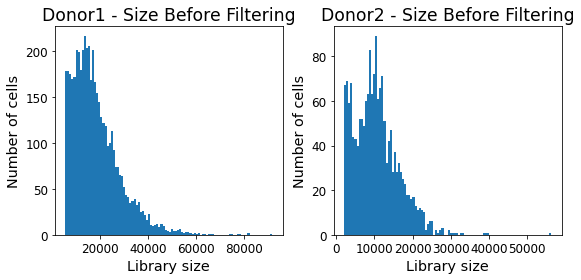

In [7]:
fig, axs = plt.subplots(1,2, figsize=(8,4))
scprep.plot.plot_library_size(d1, log=False, title='Donor1 - Size Before Filtering', ax=axs[0])
scprep.plot.plot_library_size(d2, log=False, title='Donor2 - Size Before Filtering', ax=axs[1])
plt.tight_layout()


In [8]:
filtered_batches = []

batches = [d1, d2]
cutoff = [25000, 20000]
for i,batch in enumerate(batches):
    # ==================
    # fill in your chosen `percentile` values
    batch = scprep.filter.filter_library_size(batch, cutoff=cutoff[i], keep_cells='below')
    # ==================
    filtered_batches.append(batch)

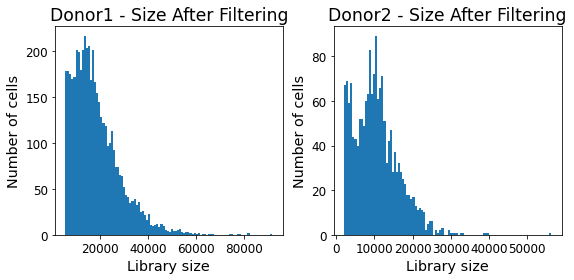

In [9]:

fig, axs = plt.subplots(1,2, figsize=(8,4))
scprep.plot.plot_library_size(d1, log=False, title='Donor1 - Size After Filtering', ax=axs[0])
scprep.plot.plot_library_size(d2, log=False, title='Donor2 - Size After Filtering', ax=axs[1])
plt.tight_layout()


### (1.2)  Merge datasets

In [10]:
data, sample_labels = scprep.utils.combine_batches(
    filtered_batches, 
    ["Donor 1", "Donor 2"]
)
data.shape


(5341, 33694)

### (1.3)  Preprocessing: Filtering, Normalizing and Transforming

<AxesSubplot:title={'center':'Mitochrondrial expression before filtering'}, xlabel='Gene expression', ylabel='Number of cells'>

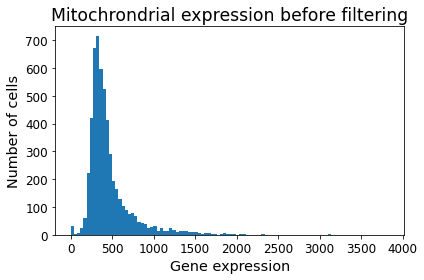

In [11]:
# Dead cell removal
scprep.plot.plot_gene_set_expression(data, starts_with="MT-",
                                     library_size_normalize=True,
                                     title="Mitochrondrial expression before filtering")

In [12]:
percentile = 90
data_filt, sample_labels = scprep.filter.filter_gene_set_expression(
    data, sample_labels, starts_with="MT-",
    percentile=percentile, keep_cells='below', library_size_normalize=True)
data_filt.shape

(4806, 33694)

<AxesSubplot:title={'center':'Mitochrondrial expression after filtering'}, xlabel='Gene expression', ylabel='Number of cells'>

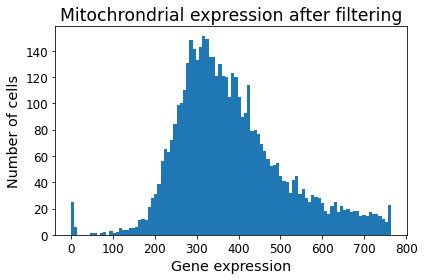

In [13]:
scprep.plot.plot_gene_set_expression(data_filt, starts_with="MT-",
                                     library_size_normalize=True,
                                     title="Mitochrondrial expression after filtering")

/cs/usr/zoe.piran/venv/lib/python3.7/site-packages/scprep/plot/histogram.py:156: MatplotlibDeprecationWarning: The 'linthreshx' parameter of __init__() has been renamed 'linthresh' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  ax.set_xscale("symlog", linthreshx=abs_min)


<AxesSubplot:title={'center':'Gene capture before filtering'}, xlabel='# of cells with nonzero expression', ylabel='# of genes'>

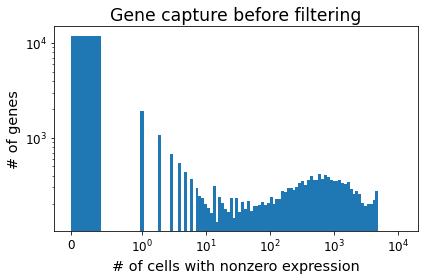

In [14]:
# Filtering lowly expressed genes
scprep.plot.histogram(scprep.measure.gene_capture_count(data_filt), log=True,
                      title="Gene capture before filtering",
                     xlabel='# of cells with nonzero expression',
                     ylabel='# of genes')

In [15]:
cutoff = 50
data_filt = scprep.filter.filter_rare_genes(data_filt, min_cells=cutoff)



/cs/usr/zoe.piran/venv/lib/python3.7/site-packages/scprep/plot/histogram.py:156: MatplotlibDeprecationWarning: The 'linthreshx' parameter of __init__() has been renamed 'linthresh' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  ax.set_xscale("symlog", linthreshx=abs_min)


<AxesSubplot:title={'center':'Gene capture after filtering'}, xlabel='# of cells with nonzero expression', ylabel='# of genes'>

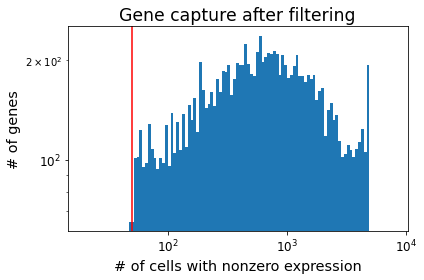

In [16]:
scprep.plot.histogram(scprep.measure.gene_capture_count(data_filt), cutoff=cutoff, log=True,
                      title="Gene capture after filtering",
                     xlabel='# of cells with nonzero expression',
                     ylabel='# of genes')

In [19]:
# normalize data
data_norm, library_size = scprep.normalize.library_size_normalize(data_filt, return_library_size=True)
metadata = pd.concat([library_size, sample_labels], axis=1)

<AxesSubplot:title={'center':'Gene counts before transformation'}, xlabel='total # of gene counts', ylabel='# of genes'>

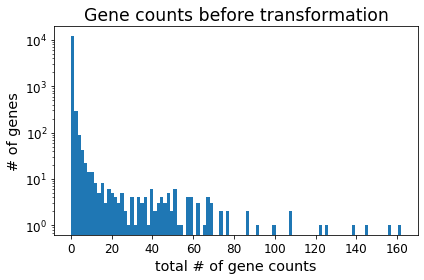

In [20]:
# gene count transformation
scprep.plot.histogram(data_norm.mean(axis=0), log='y',
                      title="Gene counts before transformation",
                     xlabel='total # of gene counts',
                     ylabel='# of genes')

In [21]:
# take sqrt of the data
data_sqrt = scprep.transform.sqrt(data_norm)

<AxesSubplot:title={'center':'Gene counts after transformation'}, xlabel='total # of gene counts', ylabel='# of genes'>

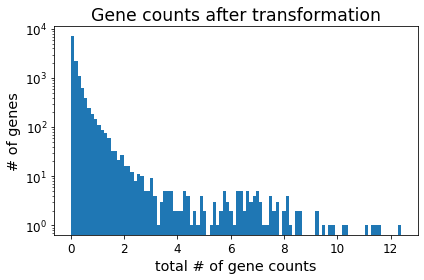

In [22]:
# plot
scprep.plot.histogram(data_sqrt.mean(axis=0), log='y',
                      title="Gene counts after transformation",
                     xlabel='total # of gene counts',
                     ylabel='# of genes')

<AxesSubplot:xlabel='Gene mean', ylabel='Standardized variance'>

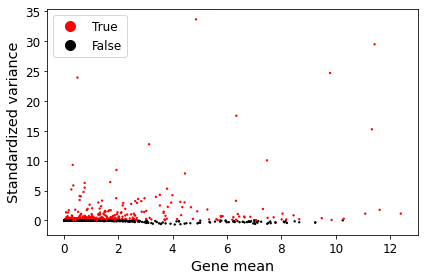

In [25]:
# highly variable genes
perc = 90
scprep.plot.plot_gene_variability(data_sqrt, percentile=perc)

In [26]:
data_hvg = scprep.select.highly_variable_genes(data_sqrt,percentile=perc)
data_hvg.shape

(4806, 1280)

<AxesSubplot:title={'center':'Highly variable genes'}, xlabel='total # of gene counts', ylabel='# of genes'>

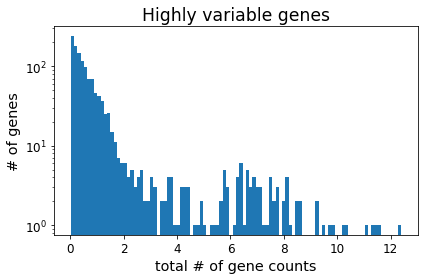

In [27]:
# plot
scprep.plot.histogram(data_hvg.mean(axis=0), log='y',
                      title="Highly variable genes",
                     xlabel='total # of gene counts',
                     ylabel='# of genes')


In [29]:
# create Anndata structs
dataset = sc.AnnData(data_hvg)
dataset.raw = sc.AnnData(data_sqrt)

### (1.4) Import reference atlas

Use given priors to spatial genes 

In [31]:

insitu_genes = np.genfromtxt(os.path.join(download_path, "atlas_epidermis"), dtype='str', max_rows=1)
atlas_matrix = np.loadtxt(os.path.join(download_path, "atlas_epidermis"), skiprows=1)

## (2) novoSpaRc reconstruction

### (2.1) Create the target space
We consider a 1D representation of the tissue assigning a singele loci for each of the eight layers

In [33]:
num_cells = 8
line_locations = np.vstack((range(num_cells), np.ones(num_cells))).T

### (2.2) Reconstruct the tissue de novo

(1) create a `Tissue` object. This is initiated by using the single cell dataset, location coordinates and optionally the output folder to save the results.



In [34]:
tissue = novosparc.cm.Tissue(dataset=dataset, locations=line_locations)

# num_neighbors_s -- number of neighbors of the source for OT setup
# num_neighbors_t -- number of neighbors of the target for OT setup
tissue.setup_reconstruction(num_neighbors_s = 3, num_neighbors_t = 3) 

Setting up for reconstruction ... done ( 49.14 seconds )


(2) reconstruct our tissue. The alpha_linear parameter controls the contribution of the two branches in novoSpaRc: `alpha_linear=0` means that no prior information is available, while `alpha_linear=1` implies that the reconstruction will be only based on the reference marker genes provided. 
Here we perform de novo reconstruction.

In [35]:
alpha_linear = 0
tissue.reconstruct(alpha_linear=alpha_linear, epsilon=5e-3)

Reconstructing spatial information with 0 markers: 4806 cells and 8 locations ... 
It.  |Err         
-------------------
    0|2.652142e-03|



-> The final object: `sDGE` (spatial gene expression matrix) holds expression values for the highly variable genes across all locations.

In [36]:
sdge_hvg = tissue.sdge
sdge = tissue.calculate_sdge_for_all_genes()

#### Plot spatial gene expression

Plot gene expression patterns in space.

In [38]:
# find indices of marker genes in the dataset
gene_names = np.asarray(dataset.var_names.to_list())
markers_in_sc = np.array([], dtype='int')
markers_in_ref = np.array([], dtype='int')
for i, marker in enumerate(insitu_genes):
    marker_index = [i for i, v in enumerate(gene_names) if marker in v]
    if len(marker_index) > 0:
        markers_in_sc = np.append(markers_in_sc, marker_index[0])
        markers_in_ref = np.append(markers_in_ref, i)

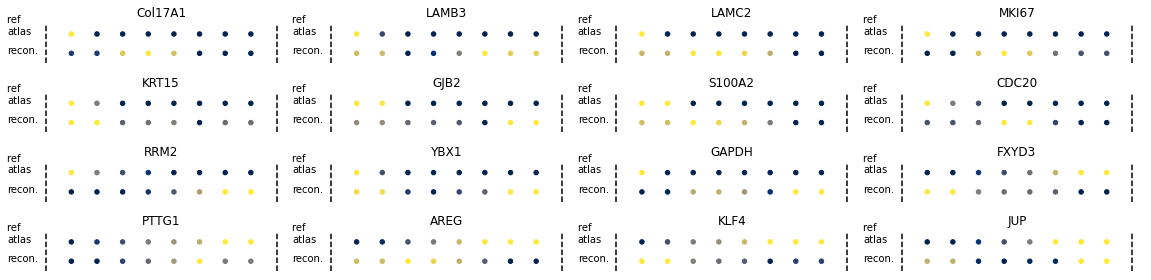

In [39]:
fig, axs = plt.subplots(4,4, figsize=(16,4))
gene = 0
for i in range(4):
    for j in range(4):
        axs[i,j].scatter(line_locations[:, 0], line_locations[:, 1]+2, c=atlas_matrix[:, markers_in_ref[gene]], s=20, cmap='cividis')
        axs[i,j].scatter(line_locations[:, 0], line_locations[:, 1], c=sdge[markers_in_sc[gene], :].flatten(), s=20, cmap='cividis')

        axs[i,j].plot([8,8], [0,4], '--', c='black')
        axs[i,j].plot([-1,-1], [0,4], '--', c='black')
        axs[i,j].set_title(insitu_genes[gene])
        axs[i,j].axis('off')
        gene += 1
        axs[i,j].text(-2.5, 1, 'recon.')
        axs[i,j].text(-2.5, 3,'ref \natlas')
plt.tight_layout()
plt.savefig('epid_denovo.jpg',dpi=300)
plt.show()    


### (2.3) Reconstruct with reference

In [37]:
# find indices of marker genes in the dataset 
dataset_raw = dataset.raw.to_adata()
gene_names = np.asarray(dataset_raw.var_names.to_list())
markers_in_sc = np.array([], dtype='int')
markers_in_ref = np.array([], dtype='int')
for i, marker in enumerate(insitu_genes):
    marker_index = [i for i, v in enumerate(gene_names) if marker in v]
    if len(marker_index) > 0:
        markers_in_sc = np.append(markers_in_sc, marker_index[0])
        markers_in_ref = np.append(markers_in_ref, i)

In [40]:
tissue_with_markers = novosparc.cm.Tissue(dataset=dataset_raw, locations=line_locations, atlas_matrix=atlas_matrix[:, markers_in_ref[:4]])
tissue_with_markers.setup_reconstruction(markers_to_use=markers_in_sc[:4])

Setting up for reconstruction ... done ( 443.29 seconds )


Set `alpha_linear > 0`. Here we choose $0.5$, meaning the geometric and gen marker components are equally weighted for the reconstruction

In [41]:
alpha_linear=0.5
tissue_with_markers.reconstruct(alpha_linear=alpha_linear, epsilon=5e-3)

Reconstructing spatial information with 4 markers: 4806 cells and 8 locations ... 
It.  |Err         
-------------------
    0|5.054561e-03|


In [42]:
sdge = tissue_with_markers.sdge

#### Plot spatial gene expression

Plot gene expression patterns in space.

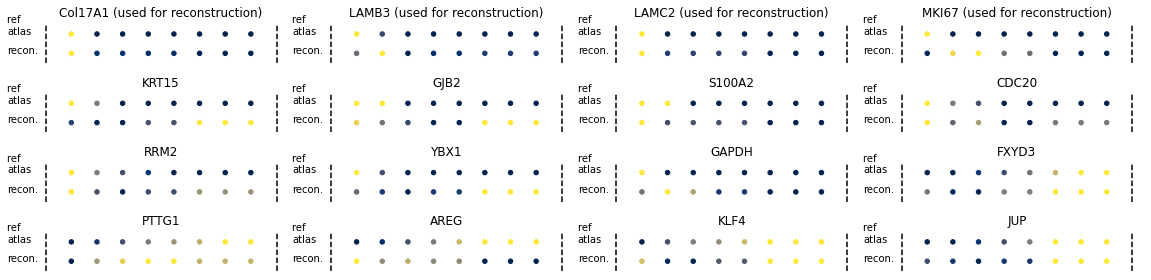

In [43]:
fig, axs = plt.subplots(4,4, figsize=(16,4))
gene = 0
for i in range(4):
    for j in range(4):
        axs[i,j].scatter(line_locations[:, 0], line_locations[:, 1]+2, c=atlas_matrix[:, markers_in_ref[gene]], s=20, cmap='cividis')
        axs[i,j].scatter(line_locations[:, 0], line_locations[:, 1], c=sdge[markers_in_sc[gene], :].flatten(), s=20, cmap='cividis')
        axs[i,j].plot([8,8], [0,4], '--', c='black')
        axs[i,j].plot([-1,-1], [0,4], '--', c='black')
        if i==0:
            axs[i,j].set_title(insitu_genes[gene] + ' (used for reconstruction)')
        else:
            axs[i,j].set_title(insitu_genes[gene])
        axs[i,j].axis('off')
        gene += 1
        axs[i,j].text(-2.5, 1, 'recon.')
        axs[i,j].text(-2.5, 3,'ref \natlas')
plt.tight_layout()
plt.savefig('epid_4markers.jpg',dpi=300)
plt.show()
